In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
batch_size=128
train_datasets = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
    )
train_loader = torch.utils.data.DataLoader(
    dataset=train_datasets,
    batch_size=batch_size,
    shuffle=True,
)
test_datasets = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_datasets,
    batch_size=batch_size,
    shuffle=True
)

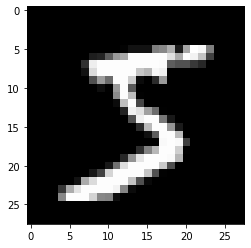

In [3]:
plt.imshow(train_datasets.data[0], cmap="gray")

## MNIST そもそものべき則グラフ

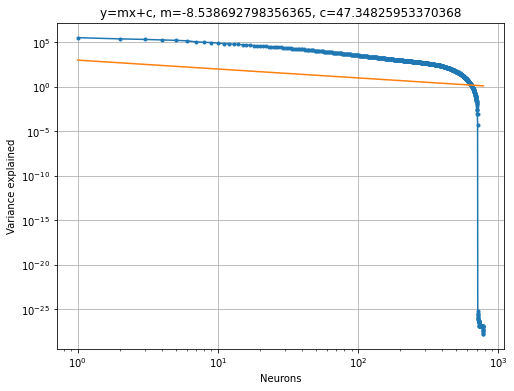

In [6]:
import sklearn
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train_datasets.data.view(-1, 784).numpy())

fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')
ax.plot(xx, 1000 * xx ** (-1.0))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
xx = np.log(xx)
yy = np.log(pca.explained_variance_)
m, c = np.linalg.lstsq(np.vstack([xx, np.ones(len(xx))]).T, yy, rcond=None)[0]
ax.set_title(f'y=mx+c, m={m}, c={c}')
ax.grid()
#ax.set_ylim(10 ** (-10))

## データの偏りをなくす
- 任意の2データ間の相関を消す (白色化)
- データ行列 $X = (x_1, x_2, ..., x_N)$ の共分散行列を対角化する行列 $P$を使って, 各データを線形変換


In [35]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-10
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix


In [36]:
data = train_datasets.data.view(-1, 784).numpy()
P = zca_whitening_matrix(data.T)
P.shape

(784, 784)

In [34]:
from kornia.enhance import ZCAWhitening
zca = ZCAWhitening()
zca.fit(train_datasets.data)

RuntimeError: mean(): input dtype should be either floating point or complex dtypes. Got Byte instead.

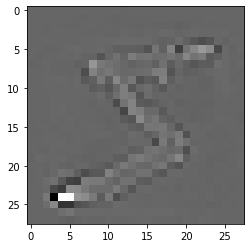

In [38]:
plt.imshow(np.dot(train_datasets.data[0].view(-1).numpy(), P).reshape(28, 28), cmap="gray")

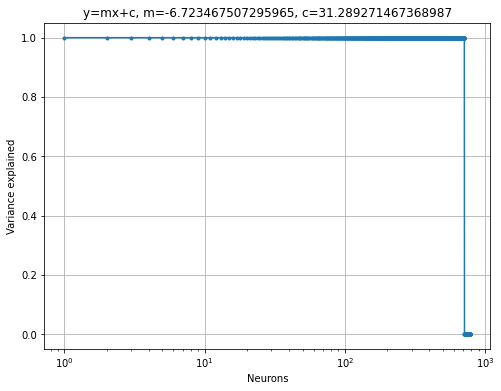

In [39]:
import sklearn
from sklearn.decomposition import PCA

data = train_datasets.data.view(-1, 784).numpy()
pca = PCA()
pca.fit(np.dot(data, P))

fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')
#ax.plot(xx, 1000 * xx ** (-1.0))

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
xx = np.log(xx)
yy = np.log(pca.explained_variance_)
m, c = np.linalg.lstsq(np.vstack([xx, np.ones(len(xx))]).T, yy, rcond=None)[0]
ax.set_title(f'y=mx+c, m={m}, c={c}')
ax.grid()


In [19]:
class Whitening(nn.Module):
    def __init__(self, zca_matrix: torch.Tensor):
        super().__init__()
        self.zca_matrix = zca_matrix

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        if tensor.size(1) * tensor.size(2) * tensor.size(3) != self.transformation_matrix.size(0):
            raise ValueError("tensor and transformation matrix have incompatible shape." +
                             "[{} x {} x {}] != ".format(*tensor[0].size()) +
                             "{}".format(self.transformation_matrix.size(0)))
        batch = tensor.size(0)

        flat_tensor = tensor.view(batch, -1)
        transformed_tensor = torch.mm(flat_tensor - self.transformation_mean, self.transformation_matrix)

        tensor = transformed_tensor.view(tensor.size())
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += (str(self.transformation_matrix.numpy().tolist()) + ')')
        return format_string


In [ ]:
whitening = Whitening(torch.from_numpy(P).float())



In [12]:
from models import RBM
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

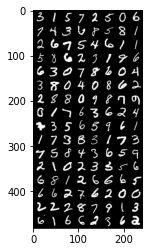

In [27]:
from torchvision.utils import make_grid

images = next(iter(train_loader))[0]
v = images.view(-1)
npimg = np.transpose(make_grid(v.view(batch_size, 1, 28, 28).data).numpy(), (1, 2, 0))
plt.imshow(npimg, cmap="gray")

In [32]:
v_white = whitening(v)
npimg = np.transpose(make_grid(v_white.view(batch_size, 1, 28, 28).data).numpy(), (1, 2, 0))
plt.imshow(npimg, cmap="gray")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100352 and 784x784)

In [21]:
lr = 0.01
n_epochs = 10
n_hid = 1024
n_vis = 784
model = RBM(n_vis=784, n_hid=1024, k=1).cpu()
from tqdm import tqdm

whitening = Whitening(torch.from_numpy(P).float())
loss_ = []
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model.train()

recon_loss_func = F.mse_loss
recon_loss_ = []
neuron_fireings = []

with tqdm(range(n_epochs)) as t:
    for epoch in t:
        vv = np.zeros((len(train_datasets), n_hid))
        for idx, (data, target)in enumerate(train_loader):
            v = data.view(-1, n_vis)
            v = whitening(v)
            v_gibbs = model(v)
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            recon_loss = recon_loss_func(v, v_gibbs)
            loss_.append(loss.item())
            recon_loss_.append(recon_loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            vv[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(v).detach().cpu().numpy()
        t.set_description(f"loss={loss.item():.2}")
        neuron_fireings.append(vv)


loss=1.7e+01: 100%|██████████| 10/10 [02:14<00:00, 13.46s/it]


(0.01, 1691.0805363204295)

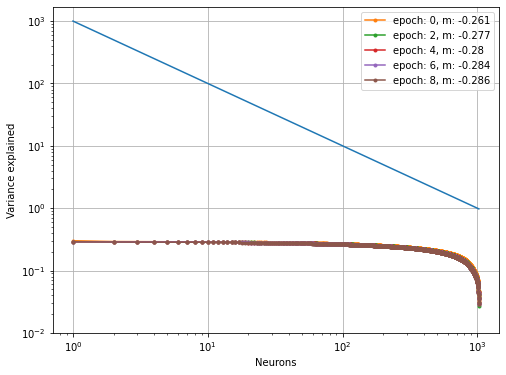

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(n_hid) + 1
log_xx = np.log(xx)
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')

for i, vv in enumerate(neuron_fireings):
    if i % 2 == 1:
        continue
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"epoch: {i}, m: {m:.3}")
plt.legend()
ax.grid()
ax.set_ylim(10 ** (-2))

In [29]:
data.target

AttributeError: 'numpy.ndarray' object has no attribute 'target'

$$\frac{||W(n) - W_0||}{||W_0||}$$